# Свертки в Keras

In [41]:
import numpy as np
from sklearn import metrics
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import pandas as pd

In [3]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
#GPU count and name
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f64f8d65-f267-bdc4-4caf-aa03fe28991c)
GPU 1: Tesla T4 (UUID: GPU-327f7dbf-4d6b-18d3-1eea-03946a005d50)


# Загрузим данные

Классы:
```
0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot
```




In [5]:
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
print(x_train.shape)
print(x_val.shape)
print (y_train[:10])
print (y_val[:10])

(60000, 28, 28)
(10000, 28, 28)
[9 0 0 3 0 2 7 2 5 5]
[9 2 1 1 6 1 4 6 5 7]


Пример картинки:


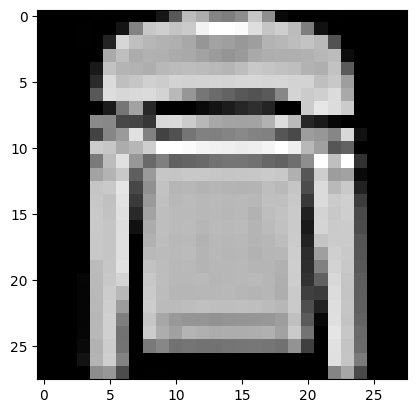

y_train [shape (60000,)] 10 примеров:
 [9 0 0 3 0 2 7 2 5 5]


In [7]:
x_train_image = np.tile(x_train[5, :, :].reshape((28, 28))[:, :, np.newaxis], (1, 1, 3))
print("Пример картинки:")
plt.imshow(x_train_image, cmap="Greys")
plt.show()
print("y_train [shape %s] 10 примеров:\n" % (str(y_train.shape)), y_train[:10])

In [8]:
# one-hot encode для ответов
y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:5], y_train[:5])

(60000, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] [9 0 0 3 0]


In [ ]:
# центрируем и нормируем, так сети будет проще учиться (позже узнаем почему :)
x_train_float = x_train.astype(np.float32) / 255 - 0.5
x_val_float = x_val.astype(np.float32) / 255 - 0.5

# Собираем модель

Будем как и в предыдущем модуле минимизировать кросс-энтропию.

In [73]:
K.clear_session()

model = M.Sequential()
model.add(L.Input(shape=(28, 28, 1)))
model.add(L.Conv2D(
    12, kernel_size=3, activation='elu',
    strides=1, padding='same')
)
model.add(L.BatchNormalization())
model.add(L.MaxPool2D())
model.add(L.Dropout(0.25))
model.add(L.Conv2D(
    24, kernel_size=5, activation='elu',
    strides=1, padding='valid')
)
model.add(L.BatchNormalization())
model.add(L.MaxPool2D())
model.add(L.Dropout(0.25))
model.add(L.Conv2D(
    48, kernel_size=3, activation='elu',
    strides=1, padding='same')
)
model.add(L.BatchNormalization())
model.add(L.MaxPool2D())
model.add(L.Dropout(0.25))
model.add(L.Conv2D(
    96, kernel_size=3, activation='elu',
    strides=1, padding='same')
)
model.add(L.BatchNormalization())
model.add(L.MaxPool2D())
model.add(L.Dropout(0.25))
model.add(L.Flatten())
model.add(L.Dense(256, activation='elu'))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.5))
model.add(L.Dense(128, activation='elu'))
model.add(L.Dropout(0.3))
model.add(L.Dense(64, activation='elu'))
model.add(L.Dense(10, activation='softmax'))

In [74]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 12)     │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 12)     │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 24)     │         7,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 10, 24)     │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 24)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 24)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 5, 48)       │        10,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 5, 48)       │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 96)       │        41,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 2, 96)       │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 1, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 127,706 (498.85 KB)

 Trainable params: 126,834 (495.45 KB)

 Non-trainable params: 872 (3.41 KB)

In [75]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [76]:
model.fit(
    x_train_float,
    y_train_oh,
    batch_size=32,
    epochs=30,
    validation_data=(x_val_float, y_val_oh)
)

Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.6107 - loss: 1.0918 - val_accuracy: 0.8216 - val_loss: 0.4901
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8006 - loss: 0.5503 - val_accuracy: 0.8556 - val_loss: 0.3917
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8382 - loss: 0.4606 - val_accuracy: 0.8741 - val_loss: 0.3452
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8464 - loss: 0.4276 - val_accuracy: 0.8708 - val_loss: 0.3558
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8634 - loss: 0.3850 - val_accuracy: 0.8754 - val_loss: 0.3465
Epoch 6/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8667 - loss: 0.3716 - val_accuracy: 0.8767 - val_loss: 0.3295
Epoch 7/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8689 - loss: 0.3655 - val_accuracy: 0.8909 - val_loss: 0.3052
Epoch 8/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8756 - loss: 0.3477 -

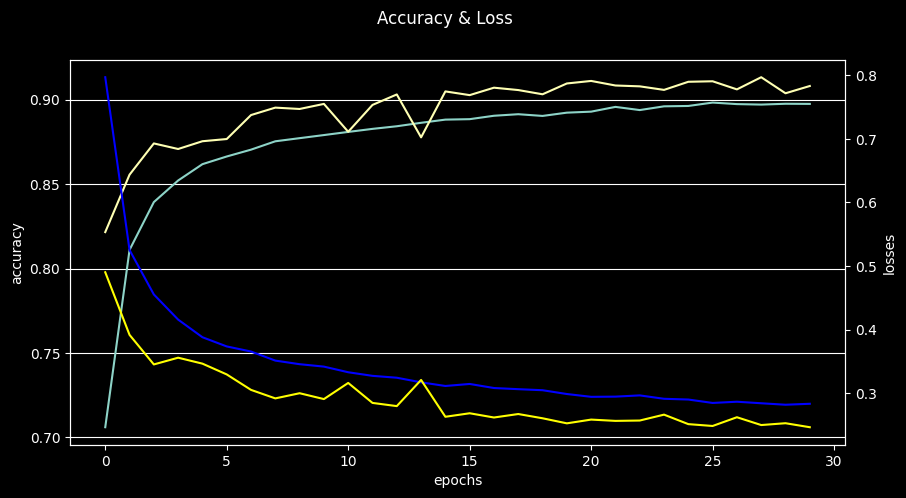

In [77]:
plt.style.use(['dark_background'])
_, ax1 = plt.subplots(sharex=True, figsize=(10, 5))
plt.suptitle('Accuracy & Loss')
ax1.plot(model.history.history['accuracy'])
ax1.plot(model.history.history['val_accuracy'])
ax1.set_xlabel('epochs')
ax1.set_ylabel('accuracy')
plt.grid(axis='y')
ax2 = ax1.twinx()
ax2.plot(model.history.history['loss'], color='b')
ax2.plot(model.history.history['val_loss'], color='yellow')
ax2.set_ylabel('losses')
plt.show()

In [78]:
predicts = np.argmax(model.predict(x_val_float), axis = 1)
print(metrics.classification_report(y_val, predicts, digits=5))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
              precision    recall  f1-score   support

           0    0.90722   0.79200   0.84570      1000
           1    0.99393   0.98200   0.98793      1000
           2    0.80659   0.93000   0.86391      1000
           3    0.90509   0.92500   0.91494      1000
           4    0.88222   0.80900   0.84403      1000
           5    0.98777   0.96900   0.97829      1000
           6    0.72622   0.75600   0.74081      1000
           7    0.93786   0.98100   0.95894      1000
           8    0.98405   0.98700   0.98552      1000
           9    0.97336   0.95000   0.96154      1000

    accuracy                        0.90810     10000
   macro avg    0.91043   0.90810   0.90816     10000
weighted avg    0.91043   0.90810   0.90816     10000

